# Examples for AtomDB manuscript




#### Example 1: Species global properties

In [1]:
from atomdb import load

c_atom = load(elem="C", charge=0, mult=3)

# Periodic Table information
print(f"Element loaded {c_atom.elem}")
print(f"Charge {c_atom.charge}")
print(f"Multiplicity {c_atom.mult}")
print(f"Number of electrons {c_atom.nelec}")
print(f"Atomic number {c_atom.atnum}")
print(f"Atomic mass in a.u. {c_atom.atmass['nist']}")
print(f"Atomic radius in a.u. {c_atom.at_radius}")

Element loaded C
Charge 0
Multiplicity 3
Number of electrons 6
Atomic number 6
Atomic mass in a.u. 21874.66184216717
Atomic radius in a.u. {'wc': 1.1716301972646734, 'cr': 1.2661165034956954}


#### Example 2: Local properties on a radial grid

1. The total electron density

In [2]:
import numpy as np

# Define a uniform radial grid and evaluate the density
rad_grid = np.linspace(0.0, 6.0, num=100)
# Density function (total)
dens_spline = c_atom.dens_func()
dens = dens_spline(rad_grid)

2. The contribution of the 1S orbital to the electron density

In [3]:
# Density function (Carbon 1s alpha orbital)
dens_spline_c1s = c_atom.dens_func(spin="a", index=[0])
dens_c1s = dens_spline_c1s(rad_grid)

Plot the computed total electron density and 1S orbital contribution.

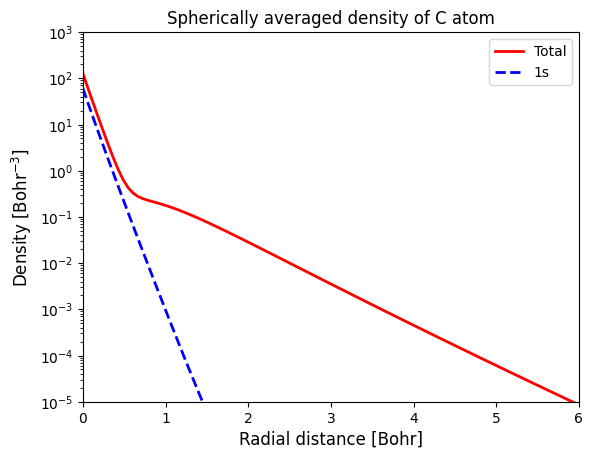

In [4]:
import numpy as np
import matplotlib.pyplot as plt


# Plot the values of the radial density
plt.plot(rad_grid, dens, "-r", linewidth=2, label="Total")
plt.plot(rad_grid, dens_c1s, "--b", linewidth=2, label="1s")
plt.xlabel("Radial distance [Bohr]", fontsize=12)
plt.ylabel("Density [Bohr$^{-3}$]", fontsize=12)
plt.yscale("log")
plt.ylim(top=1000, bottom=0.00001)
plt.xlim(left=0.0, right=6)
plt.title(f"Spherically averaged density of {c_atom.elem} atom")
plt.legend()
plt.savefig("images/c_density.pdf")
plt.show()

#### Example 3: Promolecular properties (electron density)

1. Generate reference data for the electron density and gradient

In [5]:
import iodata
from gbasis.evals.density import evaluate_density, evaluate_density_gradient
from gbasis.wrappers import from_iodata


# Load molecular data
mol_data = iodata.load_one("data/ccl2o_q+0_1.fchk")
rdm = mol_data.one_rdms["scf"]

atcoords = mol_data.atcoords
atnums = mol_data.atnums
ao_basis = from_iodata(mol_data)

print(atcoords)
print(atnums)

# Generate auxiliary grid for plotting
# Sample n points uniformly along x and y axes within [-coord_limit, coord_limit]
coord_limit = 5
plt_pts = 40
# Set the limits for the grid
plt_lmts = [-coord_limit, coord_limit, -coord_limit, coord_limit]
y_vals = x_vals = np.linspace(-coord_limit, coord_limit, plt_pts)

# Sample 3D points uniformly in the molecular xy-plane (z=0)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
x_vals, y_vals = x_vals.flatten(), y_vals.flatten()
z_vals = np.zeros_like(y_vals)
points = np.array([x_vals, y_vals, z_vals]).T  # gbasis evaluates at 3D points

print("Grid for evaluating the density matrix has shape: ", points.shape)
print(f"Distance between grid points: {2*coord_limit/(plt_pts-1)}")

# compute reference density and density gradient
rho = evaluate_density(rdm, ao_basis, points)
rho_grad = evaluate_density_gradient(rdm, ao_basis, points)

[[-2.32921510e-06 -3.09541594e+00  5.92099400e-24]
 [-4.24827662e-22 -9.20135300e-01 -6.74051222e-38]
 [ 2.72364602e+00  8.90707296e-01 -5.46293119e-24]
 [-2.72364493e+00  8.90712665e-01 -5.88717112e-24]]
[ 8  6 17 17]
Grid for evaluating the density matrix has shape:  (1600, 3)
Distance between grid points: 0.2564102564102564


2. Compute promolecular electron density and gradient at mesh points

In [6]:
import numpy as np
from atomdb import make_promolecule, element_symbol


atcoords = np.array(
    [[-2.21470275e-06, -3.10366573e+00, -6.52506695e-24],
    [ 5.77168095e-23, -9.24320633e-01,  1.37376248e-38],
    [ 2.73758052e+00,  8.93387131e-01, -1.71316666e-24],
    [-2.73757948e+00 , 8.93392257e-01, -3.00144293e-24],]

)

atnums = np.array([ 8,  6 ,17, 17])
symbols = [element_symbol(atnum) for atnum in atnums]

# Make promolecule instance
promol = make_promolecule(atnums, atcoords, dataset="slater")

promol_dens = promol.density(points)
promol_grad = promol.gradient(points)

print(f'Mass: {promol.mass()} a.u.')              # should return 180307.36...
print(f'Number of electrons: {promol.nelec()}')   # should return 48.0
print(f'Energy: {promol.energy()} a.u.')          # should return -1031.46...
print(f'Maximum density: {promol_dens.max()}')    # should return 697.21



Mass: 180307.36889952346 a.u.
Number of electrons: 48.0
Energy: -1031.462162075 a.u.
Maximum density: 697.2180128493172


#### Auxiliary code for  generating the plots

Promolecule electron density as a 2D heatmap with specified color scale limits


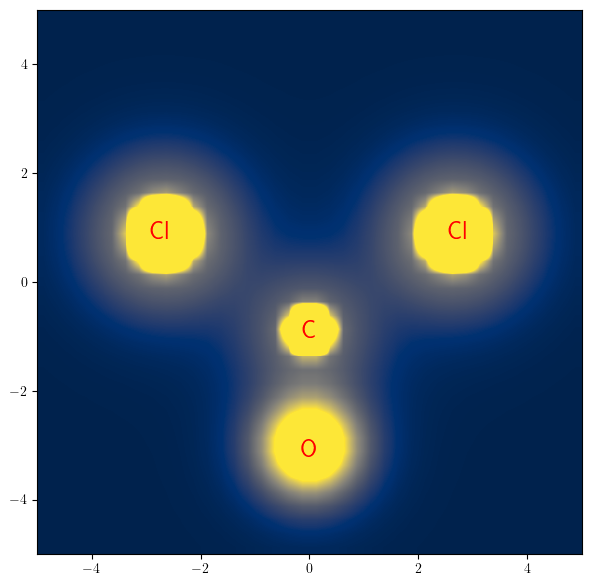

Reference electron density as a 2D heatmap same color scale limits


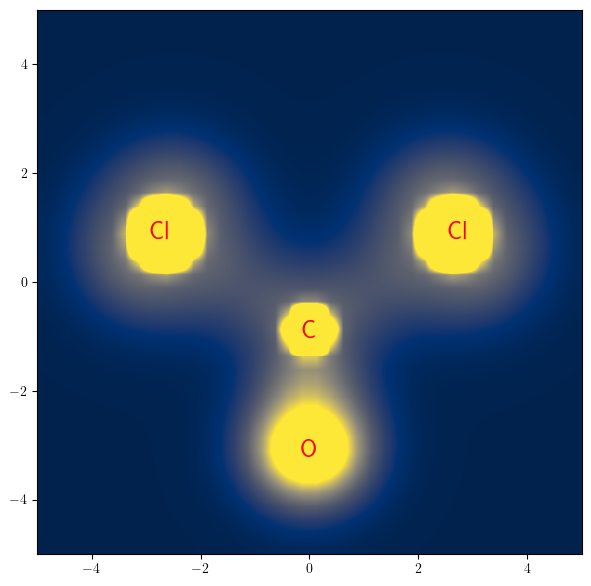

Electron density deviation respect reference as a 2D heatmap


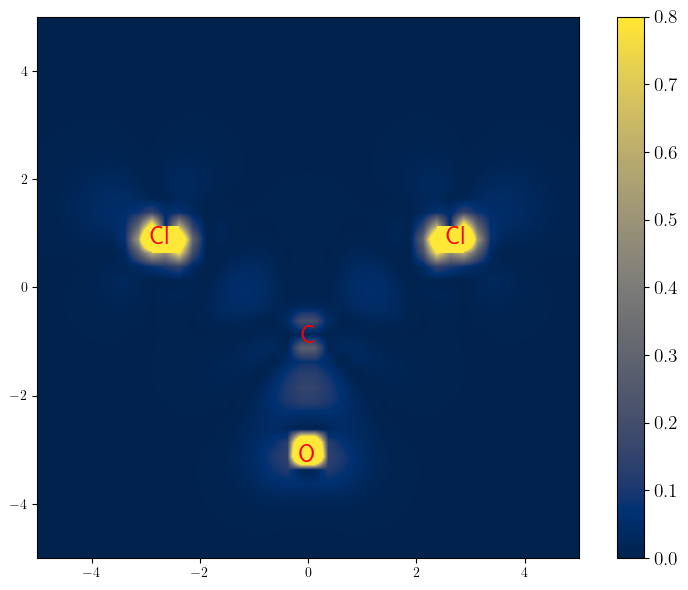

In [7]:
plt.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(6, 6))
# fig.suptitle("Electron density (promolecule)", fontsize=16)
ax1 = fig.add_subplot(111, aspect="equal")

print("Promolecule electron density as a 2D heatmap with specified color scale limits")
heatmap = ax1.imshow(
    promol_dens[::-1].reshape(plt_pts, plt_pts),
    cmap="cividis",
    interpolation="bilinear",
    extent=plt_lmts,
    vmin=0,
    vmax=0.8,
)

# Adjust the limits to fit your data and set labels and title
# Add atomic symbols to the plots
for coord, symbol in zip(atcoords[:,:2], symbols):
    ax1.text(
        coord[0],
        coord[1],
        symbol,
        color="red",
        ha="center",
        va="center",
        fontsize=18,
        fontweight="bold",
    )

plt.tight_layout()  # Adjust layout for better spacing
plt.savefig("images/electron_density_promol.pdf", bbox_inches="tight")
plt.show()


print("Reference electron density as a 2D heatmap same color scale limits")
fig = plt.figure(figsize=(6, 6))
# fig.suptitle("Electron density (reference)", fontsize=16)
ax1 = fig.add_subplot(111, aspect="equal")

# Plot the interpolated electron density as a 2D heatmap with specified color scale limits
heatmap = ax1.imshow(
    rho[::-1].reshape(plt_pts, plt_pts),
    cmap="cividis",
    interpolation="bilinear",
    extent=plt_lmts,
    vmin=0,
    vmax=0.8,
)

# Adjust the limits to fit your data and set labels and title
# Add atomic symbols to the plots
symbols = ["O", "C", "Cl", "Cl"]
xy_coords = atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(
        coord[0],
        coord[1],
        symbol,
        color="red",
        ha="center",
        va="center",
        fontsize=18,
        fontweight="bold",
    )

plt.tight_layout()  # Adjust layout for better spacing
plt.savefig("images/electron_density_reference.pdf", bbox_inches="tight")
plt.show()

print("Electron density deviation respect reference as a 2D heatmap")
fig = plt.figure(figsize=(8, 6))
# fig.suptitle("Electron density deviation", fontsize=16)
ax1 = fig.add_subplot(111, aspect="equal")

# Plot the interpolated electron density as a 2D heatmap with specified color scale limits
heatmap = ax1.imshow(
    abs((promol_dens - rho))[::-1].reshape(plt_pts, plt_pts),
    cmap="cividis",
    interpolation="bilinear",
    extent=plt_lmts,
    vmin=0,
    vmax=0.8,
)
cbar = plt.colorbar(heatmap, ax=ax1)
cbar.ax.tick_params(labelsize=14)
# cbar.ax.set_ylabel(r'$\|\rho(r)^{\mathrm{reference}} - \rho(r)^{\mathrm{promolecule}}\|$', fontsize=16)


# Adjust the limits to fit your data and set labels and title
# Add atomic symbols to the plots
symbols = ["O", "C", "Cl", "Cl"]
xy_coords = atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(
        coord[0],
        coord[1],
        symbol,
        color="red",
        ha="center",
        va="center",
        fontsize=18,
        fontweight="bold",
    )

plt.tight_layout()  # Adjust layout for better spacing
plt.savefig("images/electron_density_dev.pdf", bbox_inches="tight")
plt.show()


Reference electron density gradient as a 2D heatmap with quiver plot


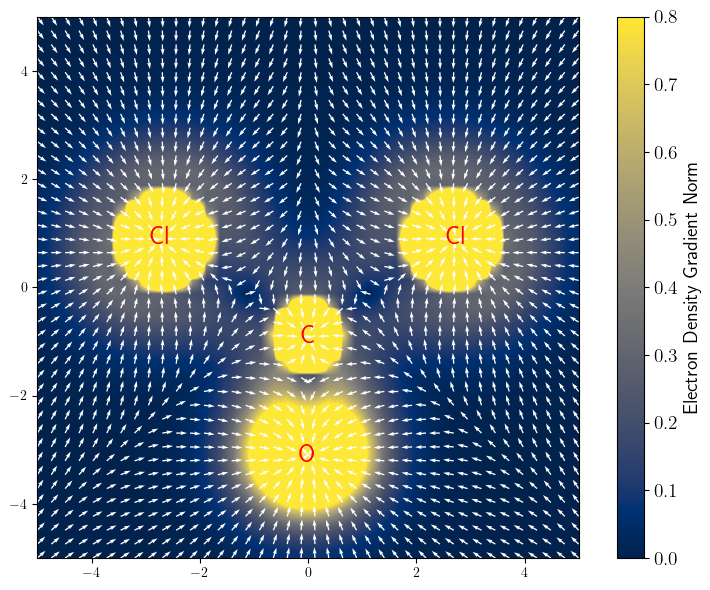

Promolecule electron density gradient as a 2D heatmap with quiver plot


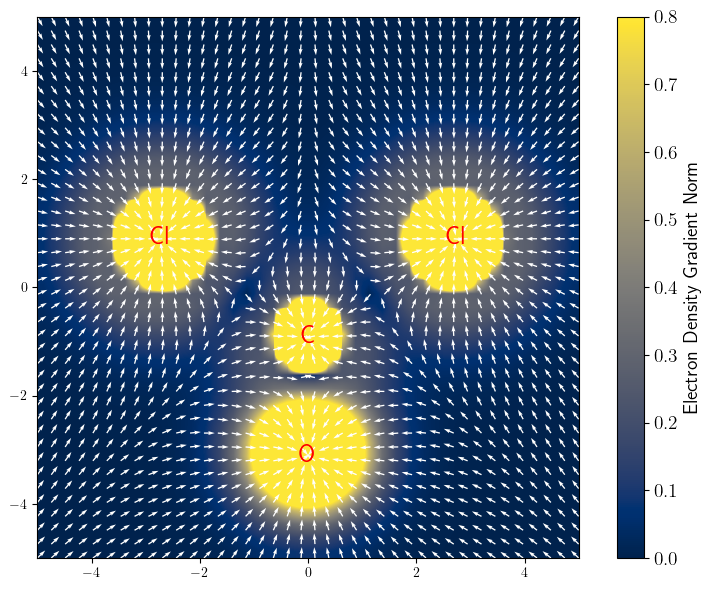

In [8]:
print("Reference electron density gradient as a 2D heatmap with quiver plot")

# find the norm of the gradient vectors
rho_grad_norm = np.linalg.norm(rho_grad, axis=1)[::-1]
rho_grad_prom_norm = np.linalg.norm(promol_grad, axis=1)[::-1]

# use fixed length for the gradient vectors
grad_length = 0.2
rho_grad_sc = rho_grad / np.linalg.norm(rho_grad, axis=1)[:, None] * grad_length
rho_grad_prom_sc = promol_grad / np.linalg.norm(promol_grad, axis=1)[:, None] * grad_length

fig = plt.figure(figsize=(8, 6))
# fig.suptitle("Gradient of the electron density (reference)", fontsize=16)
ax1 = fig.add_subplot(111, aspect="equal")

# Plot the interpolated electron density as a 2D heatmap with specified color scale limits
heatmap = ax1.imshow(
    rho_grad_norm.reshape(plt_pts, plt_pts),
    cmap="cividis",
    interpolation="bilinear",
    extent=plt_lmts,
    vmin=0,
    vmax=0.8,
)
cbar = plt.colorbar(heatmap, ax=ax1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Electron Density Gradient Norm ", fontsize=14)

# Plot the vectorial map (omit the z-component) of the analytical gradient
ax1.quiver(
    points[:, 0],
    points[:, 1],
    rho_grad_sc[:, 0],
    rho_grad_sc[:, 1],
    color="w",
    angles="xy",
    scale_units="xy",
    scale=1,
)

# Adjust the limits to fit your data and set labels and title
# Add atomic symbols to the plots
symbols = ["O", "C", "Cl", "Cl"]
xy_coords = atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(
        coord[0],
        coord[1],
        symbol,
        color="red",
        ha="center",
        va="center",
        fontsize=18,
        fontweight="bold",
    )

plt.tight_layout()  # Adjust layout for better spacing
plt.savefig("images/gradient_reference.pdf", bbox_inches="tight")
plt.show()

print("Promolecule electron density gradient as a 2D heatmap with quiver plot")
fig2 = plt.figure(figsize=(8, 6))
# fig2.suptitle("Gradient of the electron density (promolecule)", fontsize=16)
ax1 = fig2.add_subplot(111, aspect="equal")

# Plot the interpolated electron density as a 2D heatmap with specified color scale limits
heatmap = ax1.imshow(
    rho_grad_prom_norm.reshape(plt_pts, plt_pts),
    cmap="cividis",
    interpolation="bilinear",
    extent=plt_lmts,
    vmin=0,
    vmax=0.8,
)
cbar = plt.colorbar(heatmap, ax=ax1)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Electron Density Gradient Norm ", fontsize=14)

# Plot the vectorial map (omit the z-component) of the analytical gradient
ax1.quiver(
    points[:, 0],
    points[:, 1],
    rho_grad_prom_sc[:, 0],
    rho_grad_prom_sc[:, 1],
    color="w",
    angles="xy",
    scale_units="xy",
    scale=1,
)

# Adjust the limits to fit your data and set labels and title
# Add atomic symbols to the plots
xy_coords = atcoords[:, :2]
for coord, symbol in zip(xy_coords, symbols):
    ax1.text(
        coord[0],
        coord[1],
        symbol,
        color="red",
        ha="center",
        va="center",
        fontsize=18,
        fontweight="bold",
    )

plt.tight_layout()  # Adjust layout for better spacing
plt.savefig("images/gradient_promolecule.pdf", bbox_inches="tight")
plt.show()

In [9]:
promol = make_promolecule(atnums, atcoords, dataset="nist")

# Intensive properties
print(f'Ionization potential: {promol.ip()} a.u.') # output 0.466841
print(f'Chemical potential: {promol.mu()} a.u.')   # output -0.27911
print(f'Chemical hardness: {promol.eta()}')        # output 0.375394

Ionization potential: 0.46684143119951305 a.u.
Chemical potential: -0.27911110192409483 a.u.
Chemical hardness: 0.3753943260243093
